In [1]:
import os
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
A = loadmat("./Data_P3/A.mat")["A"]
b = loadmat("./Data_P3/b.mat")["b"]
lamda = loadmat("./Data_P3/lambda.mat")["lambda"]
nu = loadmat("./Data_P3/nu.mat")["nu"]
P = loadmat("./Data_P3/P.mat")["P"]
q = loadmat("./Data_P3/q.mat")["q"]
X0 = loadmat("./Data_P3/X0.mat")["x_0"]

In [3]:
class Func():
    def __init__(self, A, b, P, q):
        self.delta = 1e-11
        self.epsilon = 1e-11
        self.A = A
        self.n = A.shape[1]
        self.m = A.shape[0]
        self.b = b
        self.P = P
        self.q = q
        
    def phi(self, X):
        return -np.sum(np.log(X))
        
    def value(self, X):
        return 1/2*X.T@self.P@X + self.q.T@X
    
    def barrier_value(self, X, t):
        return t*self.value(X) + self.phi(X)
    
    def dual_value(self, lamda, nu):
        tmp = np.linalg.inv(self.P)@(lamda-self.q-self.A.T@nu)
        return -nu.T@self.b + (1/2*tmp.T@self.P+self.q.T-lamda.T+nu.T@self.A)@tmp
    
    def grad(self, X):
        return self.P@X + self.q
    
    def phi_grad(self, X):
        return -1/X
    
    def barrier_grad(self, X, t):
        return t*self.grad(X) + self.phi_grad(X)
    
    def hessian(self, X):
        return self.P
    
    def phi_hessian(self, X):
        return np.eye(self.n)/(X**2)
    
    def barrier_hessian(self, X, t):
        return t*self.hessian(X) + self.phi_hessian(X)
    
    def diff_1D(self, X, D, t):
        return np.dot(self.grad(X+t*D).T, D)
    
    def barrier_diff_1D(self, X, D, t, step):
        return np.dot(self.barrier_grad(X+step*D, t).T, D)
    
    def diff_2_1D(self, X, D, t):
        return np.dot(D.T, np.dot(self.hessian(X+t*D), D))
    
    def barrier_diff_2_1D(self, X, D, t, step):
        return np.dot(D.T, np.dot(self.barrier_hessian(X+step*D, t), D))
    
    def r_t(self, X, lamda, nu, t):
        r_dual = self.grad(X)-lamda+self.A.T@nu
        r_cent = (np.eye(self.n)*lamda)@X-np.ones(X.shape)/t
        r_pri = self.A@X-self.b
        return r_dual, r_cent, r_pri
    
    def r_t_norm(self, X, lamda, nu, t):
        r_dual, r_cent, r_pri = self.r_t(X, lamda, nu, t)
        r = np.concatenate([r_dual, r_cent, r_pri], axis=0)
        return np.linalg.norm(r)
    
    def Newton_1D_Method(self, X0, D, delta):#一维精确搜索——牛顿法
        t_tmp=0
        while(abs(self.diff_t(X0,D,t_tmp))>delta or delta_t>1e-3):
            t_tmp = new_t_tmp
            #if(np.sum((X0+t_tmp+D<=0))>0):
            #    break
            new_t_tmp=t_tmp-self.diff_t(X0,D,t_tmp)/self.diff_2_t(X0,D,t_tmp)
            delta_t = np.abs(new_t_tmp - t_tmp)
            t_tmp = new_t_tmp
        return X0+t_tmp*D
    
    def barrier_Backtracking1(self, X0, D, t, delta, alpha = 0.2, beta = 0.7):
        step = 1
        """↓↓↓↓↓↓↓↓控制步长，防止走出函数定义域↓↓↓↓↓↓↓↓"""
        idxs = np.where(X0+step*D<0)
        scale = np.abs(X0[idxs])/np.abs((step*D)[idxs])
        if(scale.shape[0]>0):
            step = step*np.min(scale)*0.99
        """↑↑↑↑↑↑↑↑控制步长，防止走出函数定义域↑↑↑↑↑↑↑↑"""
        while(self.barrier_value(X0+step*D, t) > self.barrier_value(X0, t) + alpha*step*np.dot(self.barrier_grad(X0, t).T, D)):
            step = beta*step
        return X0+step*D
    
    def Backtracking2(self, X0, lamda0, nu0, delta_x, delta_lamda, delta_nu, t, delta, alpha = 0.4, beta = 0.9):
        idxs = np.where(delta_lamda<0)
        step = np.min(-lamda0[idxs]/delta_lamda[idxs])
        if(step>1):
            step=1
        """↓↓↓↓↓↓↓↓控制步长，防止走出函数定义域↓↓↓↓↓↓↓↓"""
        idxs = np.where(X0+step*delta_x<0)
        scale = np.abs(X0[idxs])/np.abs((step*delta_x)[idxs])
        if(scale.shape[0]>0):
            step = step*np.min(scale)*0.99
        """↑↑↑↑↑↑↑↑控制步长，防止走出函数定义域↑↑↑↑↑↑↑↑"""
        while(self.r_t_norm(X0+step*delta_x, lamda0+step*delta_lamda, nu0+step*delta_nu, t) > (1-alpha*step)*self.r_t_norm(X0, lamda0, nu0, t)):
            step = beta*step
        #print(step)
        return X0+step*delta_x, lamda0+step*delta_lamda, nu0+step*delta_nu
    
    def BarrierNewtonMethod(self, X0, lamda0, nu0, t, epsilon = 1e-12, max_iter = 100):
        tmp_x = X0
        num_iter = 0
        dual_gaps = []
        while(num_iter<max_iter):
            hessian = self.barrier_hessian(tmp_x, t)
            hessian_inv = np.linalg.inv(hessian)
            a = np.dot(hessian_inv, self.A.T)
            b = np.dot(hessian_inv, self.barrier_grad(tmp_x, t))
            S = -np.dot(self.A, a)
            w = np.dot(np.dot(np.linalg.inv(S), self.A), b)
            d = -np.dot(hessian_inv, (np.dot(self.A.T, w))) - b
            tmp_x = self.barrier_Backtracking1(tmp_x, d, t, self.delta)
            lambda_square = np.dot(d.T, np.dot(hessian, d))
            dual_gaps.append((self.n/t).copy())
            #print("error: ", lambda_square/2)
            if(lambda_square/2 <= epsilon):
                break
            num_iter+=1
                
        return tmp_x, w/t, dual_gaps
    
    def BarrierMethod(self, X0, lamda0, nu0, epsilon, mu = 10):
        tmp_x = X0.copy()
        tmp_lamda = lamda0.copy()
        tmp_nu = nu0.copy()
        tmp_dual_gap = self.value(tmp_x) - self.dual_value(tmp_lamda, tmp_nu)
        tmp_t = self.n/abs(tmp_dual_gap)
        #print(self.value(tmp_x), self.dual_value(tmp_lamda, tmp_nu))
        dual_gaps = [self.n/tmp_t]
        while(True):
            tmp_x, tmp_nu, dual_gapp= self.BarrierNewtonMethod(tmp_x, tmp_lamda, tmp_nu, tmp_t, 1e-10)
            tmp_lamda = 1/(tmp_t*tmp_x)
            tmp_dual_gap = abs(self.value(tmp_x) - self.dual_value(tmp_lamda, tmp_nu))
            #print(tmp_t, self.n/tmp_t, tmp_dual_gap)
            if(self.n/tmp_t < epsilon):
                break
            tmp_t = mu*tmp_t
            dual_gaps.extend(dual_gapp)
        
        return tmp_x, tmp_lamda, tmp_nu, self.value(tmp_x), np.array(dual_gaps).reshape(-1)
    
    def PrimalDualInteriorPointMethod(self, X0, lamda0, nu0, epsilon, mu = 10):
        eta_list = []
        dual_res_list = []
        tmp_x = X0.copy()
        tmp_lamda = lamda0.copy()
        tmp_nu = nu0.copy()
        eta = tmp_x.T@tmp_lamda
        tmp_t = mu*self.n/eta
        r_dual, r_cent, r_pri = self.r_t(tmp_x, tmp_lamda, tmp_nu, tmp_t)
        eta_list.append(eta.copy())
        dual_res_list.append(np.linalg.norm(np.concatenate([r_dual, r_pri], axis=0)))
        while(np.linalg.norm(r_dual)>epsilon or eta>epsilon or np.linalg.norm(r_pri)>epsilon):
            H_pd = self.hessian(tmp_x) + (np.eye(self.n)*tmp_lamda)@(np.eye(self.n)/tmp_x)
            H_pd_inv = np.linalg.inv(H_pd)
            diag_x_inv = np.linalg.inv(np.eye(self.n)*tmp_x)
            delta_nu = np.linalg.inv(self.A@H_pd_inv@self.A.T)@(r_pri-self.A@H_pd_inv@(r_dual+diag_x_inv@r_cent))
            delta_x = -np.linalg.inv(H_pd)@(r_dual+diag_x_inv@r_cent+self.A.T@delta_nu)
            delta_lamda = -(diag_x_inv@((np.eye(self.n)*tmp_lamda)@delta_x+r_cent))
            tmp_x, tmp_lamda, tmp_nu = self.Backtracking2(tmp_x, tmp_lamda, tmp_nu, delta_x, delta_lamda, delta_nu, tmp_t, self.delta)
            eta = tmp_x.T@tmp_lamda
            tmp_t = mu*self.n/eta
            r_dual, r_cent, r_pri = self.r_t(tmp_x, tmp_lamda, tmp_nu, tmp_t)
            eta_list.append(eta.copy())
            dual_res_list.append(np.linalg.norm(np.concatenate([r_dual, r_pri], axis=0)))

        return tmp_x, tmp_lamda, tmp_nu, self.value(tmp_x), np.array(eta_list).reshape(-1), np.array(dual_res_list).reshape(-1)

In [4]:
func1 = Func(A, b, P, q)
opt_x, opt_lamda, opt_nu, opt_value, dual_gaps = func1.BarrierMethod(X0, lamda, nu, epsilon=1e-10)

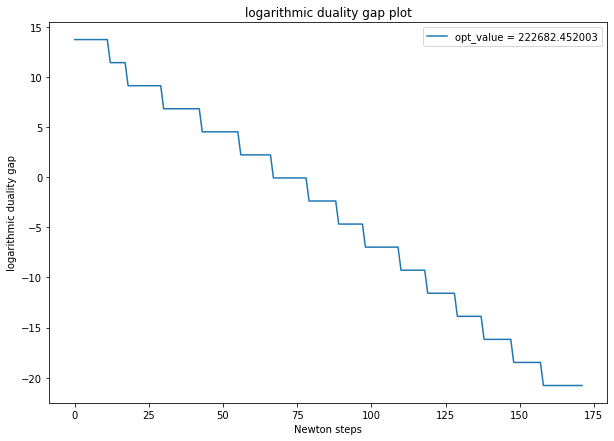

In [5]:
plt.figure(figsize=(10,7))
plt.plot(np.log(dual_gaps), "-", label = "opt_value = %f"%(opt_value))
plt.xlabel("Newton steps")
plt.ylabel("logarithmic duality gap")
plt.title("logarithmic duality gap plot")
plt.legend()
plt.show()

In [6]:
opt_x, opt_lamda, opt_nu, opt_value, eta_list, dual_res_list = func1.PrimalDualInteriorPointMethod(X0, lamda, nu, epsilon=1e-10, mu=10)

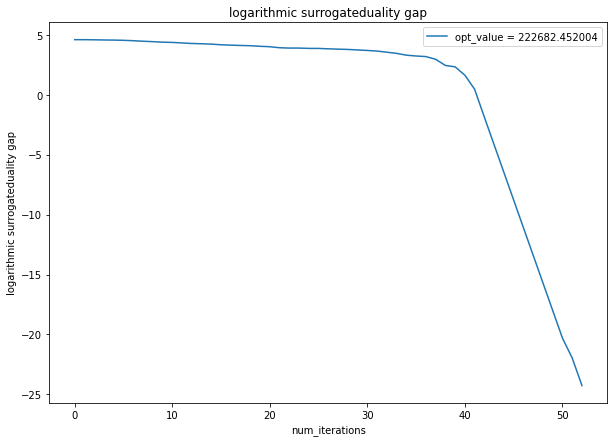

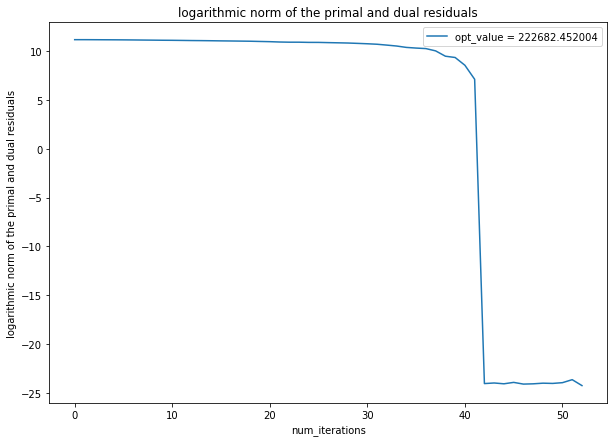

In [7]:
plt.figure(figsize=(10,7))
plt.plot(np.log(eta_list), "-", label = "opt_value = %f"%(opt_value))
plt.xlabel("num_iterations")
plt.ylabel("logarithmic surrogateduality gap")
plt.title("logarithmic surrogateduality gap")
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(np.log(dual_res_list), "-", label = "opt_value = %f"%(opt_value))
plt.xlabel("num_iterations")
plt.ylabel("logarithmic norm of the primal and dual residuals")
plt.title("logarithmic norm of the primal and dual residuals")
plt.legend()
plt.show()